# Récupération de data : train and set

In [9]:
import pandas as pd

In [10]:
trainset = pd.read_csv('data/data_after_preprocessing/trainset.csv', sep=',')
testset = pd.read_csv('data/data_after_preprocessing/testset.csv', sep=',')

In [11]:
X_train = trainset.drop('SARS-Cov-2 exam result', axis=1)
y_train = trainset['SARS-Cov-2 exam result']

In [12]:
X_test = testset.drop('SARS-Cov-2 exam result', axis=1)
y_test = testset['SARS-Cov-2 exam result']

# Modelisation ML

In [13]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [22]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))

*On instancie nos model avec leurs paramètres de base*

In [23]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler() , SVC(random_state=0))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

In [24]:
dict_of_models = {
    'RandomForest': RandomForest,
    'AdaBoost': AdaBoost,
    'SVM': SVM,
    'KNN': KNN
}

*ON tente d'évaluer chaque model*

In [25]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt
import numpy as np

In [26]:
def evaluate(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"F1 score: {f1_score(y_test, y_pred)}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                               cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))

    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label="train_score")
    plt.plot(N, val_score.mean(axis=1), label="train_score")

RandomForest
F1 score: 0.4
[[91  4]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111

AdaBoost
F1 score: 0.5185185185185185
[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111



C:\Program Files\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Program Files\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Program Files\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Program Files\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\P

SVM
F1 score: 0.48
[[92  3]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        95
           1       0.67      0.38      0.48        16

    accuracy                           0.88       111
   macro avg       0.78      0.67      0.71       111
weighted avg       0.87      0.88      0.87       111

KNN
F1 score: 0.5161290322580645
[[88  7]
 [ 8  8]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92        95
           1       0.53      0.50      0.52        16

    accuracy                           0.86       111
   macro avg       0.72      0.71      0.72       111
weighted avg       0.86      0.86      0.86       111



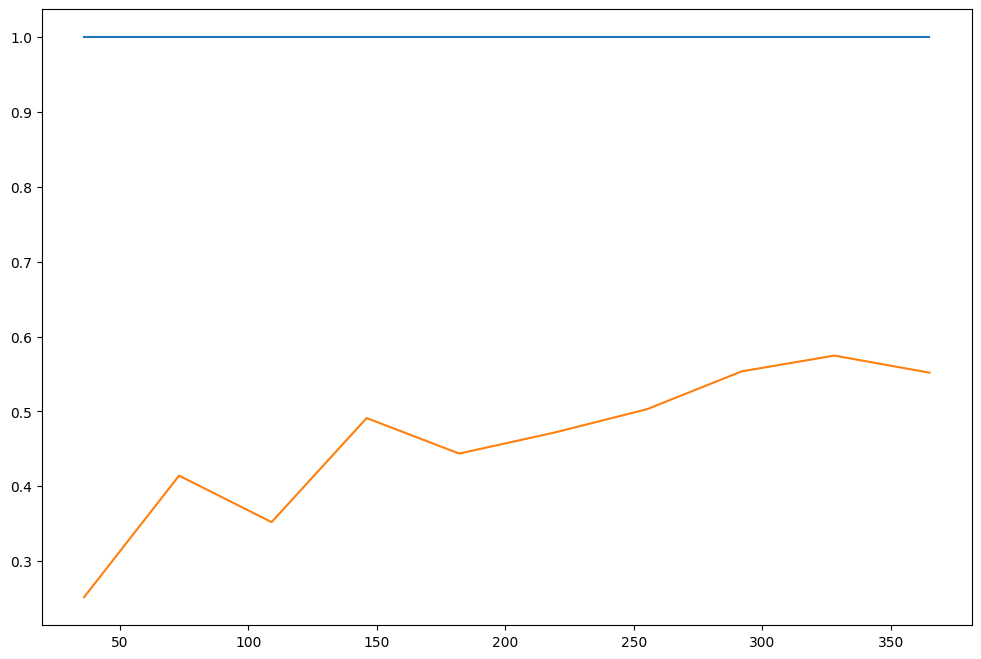

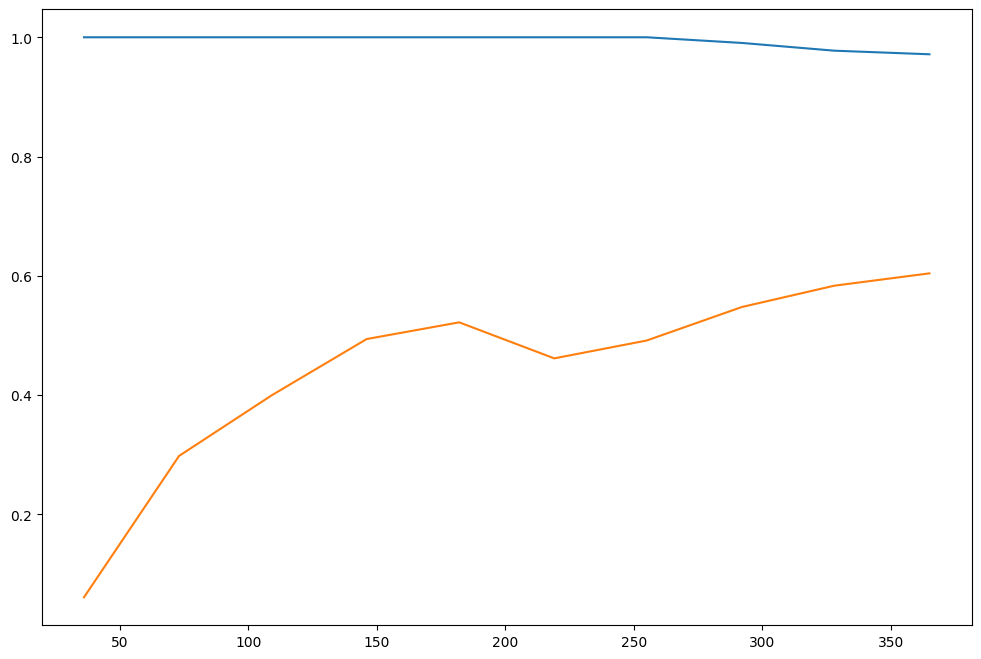

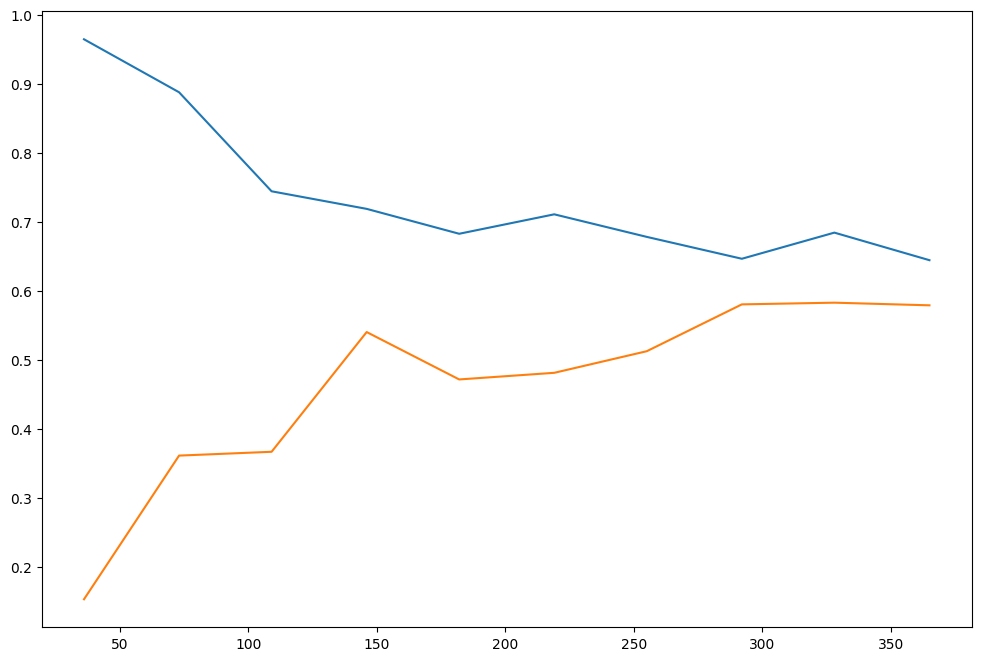

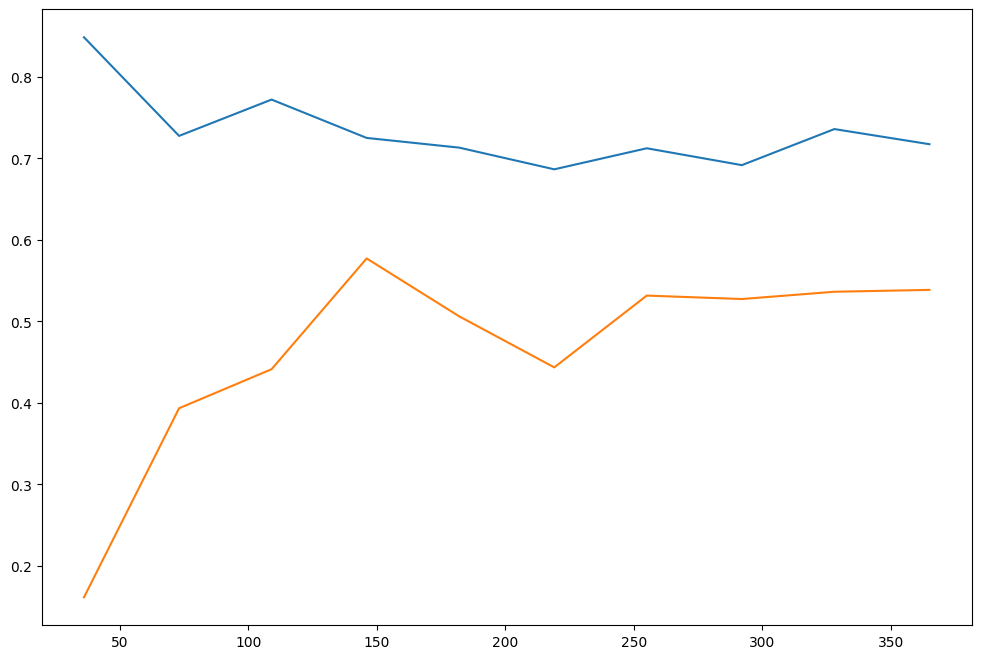

In [27]:
for name, model in dict_of_models.items():
    print(name)
    evaluate(model)

Nous allons nous baser sur Adaboost et SVM qui donne un bon score.
Nous laissons KNN qui prédit un bon score, car il est basé sur les instances, adapté aux données qu'on lui fournit.

# OPTIMISATION

In [30]:
from sklearn.model_selection import GridSearchCV

In [32]:
print(SVM)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest())])),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=0))])


In [33]:
hyper_params = {'svc__gamma': [1e-3, 1e-4],
                'svc__C': [1, 10, 100, 1000]}

In [37]:
grid = GridSearchCV(SVM, hyper_params, scoring='recall', cv=4)
# ON cherche à minimiser le recall : le nombre de hens positifs à la Covid, mais qu'on ne les détecte pas.

In [38]:
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

{'svc__C': 1000, 'svc__gamma': 0.001}
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        95
           1       0.70      0.44      0.54        16

    accuracy                           0.89       111
   macro avg       0.81      0.70      0.74       111
weighted avg       0.88      0.89      0.88       111



ON voit qu'on a une amélioration par rapport a ce qu'on vient de faire

F1 score: 0.5384615384615384
[[92  3]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        95
           1       0.70      0.44      0.54        16

    accuracy                           0.89       111
   macro avg       0.81      0.70      0.74       111
weighted avg       0.88      0.89      0.88       111



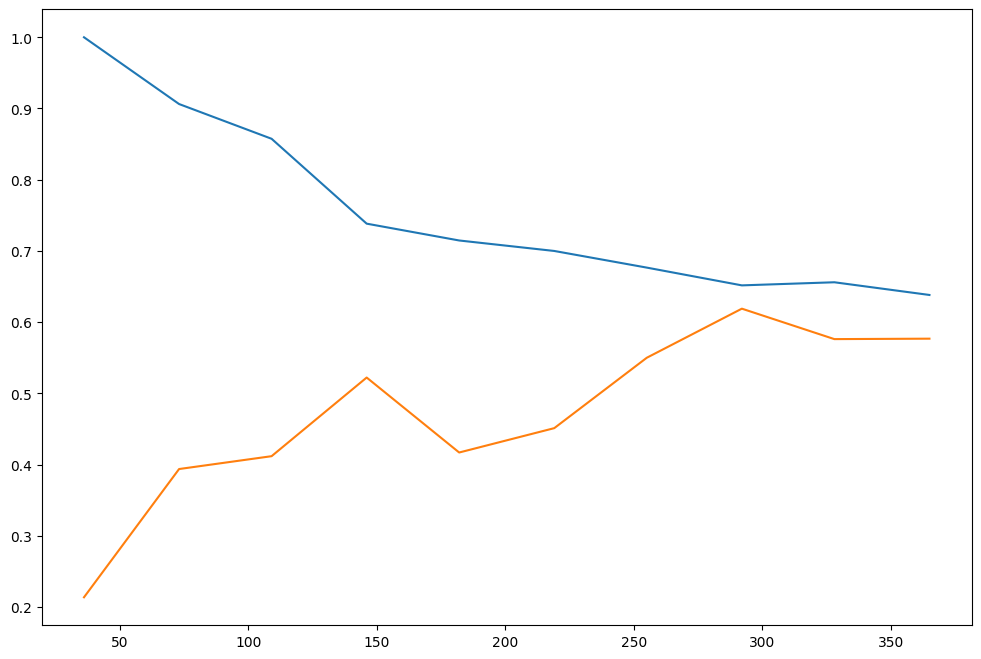

In [39]:
evaluate(grid.best_estimator_)

On voit que :
- La courbe du train diminue,
- La courbe de test augmente
- On commence à atteindre un palier où les deux courbes se rejoignent.

C'est très bien de constater ça, car ça nous indique que le modèle n'est surtout pas en overfitting.
Le train est à peu près égal au test → donc le modèle est capable de généraliser

#### Comment réussir à pousser le modèle encore plus loin

*On pourrait utiliser RandomizedSearchCV à la place de GridSearchCV*

In [40]:
from sklearn.model_selection import RandomizedSearchCV

In [42]:
print(SVM)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest())])),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=0))])


In [67]:
hyper_params = {'svc__gamma': [1e-3, 1e-4],
                'svc__C': [1, 10, 100, 1000],
                'pipeline__polynomialfeatures__degree': [2, 3, 4],
                'pipeline__selectkbest__k': range(40, 60)}

# au debut c'était un range(4, 100), ensuite range(40, 60) et ainsi de suite pour obtenir un bon score

In [68]:
grid = RandomizedSearchCV(SVM, hyper_params, scoring='recall', cv=4, n_iter=40)
grid.fit(X_train, y_train)

print(grid.best_params_)
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

{'svc__gamma': 0.001, 'svc__C': 1000, 'pipeline__selectkbest__k': 44, 'pipeline__polynomialfeatures__degree': 3}
              precision    recall  f1-score   support

           0       0.92      0.93      0.92        95
           1       0.53      0.50      0.52        16

    accuracy                           0.86       111
   macro avg       0.72      0.71      0.72       111
weighted avg       0.86      0.86      0.86       111



Ce résultat n'est pas mal

# Precision Recall Curve

In [69]:
from sklearn.metrics import precision_recall_curve

In [70]:
precision, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.decision_function(X_test))

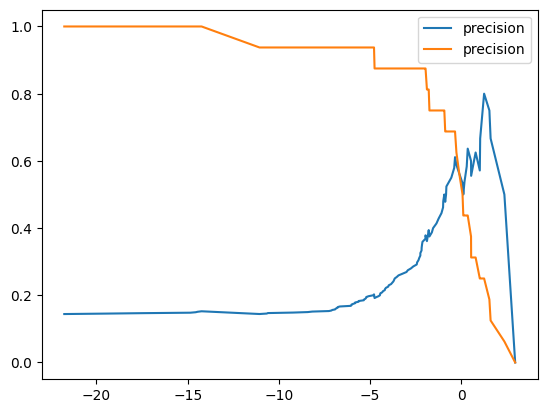

In [76]:
plt.figure()
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='precision')
plt.legend()

- On pourrait être tenté de choisir le threshold = 0, où les courbes se croisent.
- Mais on va sacrifier notre precision pour obtenir un recall un peu élevé. Ainsi choisir un threshold = -1

#### Alors comment le faire ?

In [77]:
def model_final(model, X, threshold=0):
    return model.decision_function(X) > threshold

In [78]:
y_pred = model_final(grid.best_estimator_, X_test, threshold=-1)

In [79]:
f1_score(y_test, y_pred)

0.5853658536585366

C'est vraiment pas mal

In [80]:
from sklearn.metrics import recall_score

In [81]:
recall_score(y_test, y_pred)

0.75

C'est vraiment pas mal